<a name='c1w1-1.'></a>
## 1. Ingest and transform the dataset :copy dataset from public s3 to notebook local storage, transform data, save it in s3.


In [ ]:
# please ignore warning messages during the installation
!pip install --disable-pip-version-check -q sagemaker==2.35.0
!pip install --disable-pip-version-check -q pandas==1.1.4
!pip install --disable-pip-version-check -q awswrangler==2.7.0
!pip install --disable-pip-version-check -q numpy==1.18.5
!pip install --disable-pip-version-check -q seaborn==0.11.0
!pip install --disable-pip-version-check -q matplotlib===3.3.3

import boto3 #AWS SDK for Python to create, configure, manage AWS services like EC2, S3.Provides an object-oriented API as well as low-level access to AWS services.
import sagemaker #SageMaker Python SDK which provides several high-level abstractions for working with the Amazon SageMaker.
import pandas as pd, numpy as np, botocore

config = botocore.config.Config(user_agent_extra='dlai-pds/c1/w1')
# low-level service client of the boto3 session
sm = boto3.client(service_name='sagemaker', config=config) 
sess = sagemaker.Session(sagemaker_client=sm)

bucket = sess.default_bucket() #dafault_bucket that has been created for all account. change deafault bucket to the name of an existing custom bucket if you need to change to custom bucket
role = sagemaker.get_execution_role() #uses an sts service to grab iam policy of notebook and give sagemaker access to our s3 bucket
region = sess.boto_region_name
account_id = sess.account_id()
print('S3 Bucket: {}'.format(bucket), ' Region: {}'.format(region), 'Account ID: {}'.format(account_id))

In [ ]:
#download dataset from s3
!aws s3 cp s3://dlai-practical-data-science/data/raw/womens_clothing_ecommerce_reviews.csv .//womens_clothing_ecommerce_reviewss.csv #to copy the s3file to the local or anathor s3 path

#Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

#read csv
df=pd.read_csv('./c1w1/womens_clothing_ecommerce_reviews.csv', index_col = 0)

#table analysis
# df.shape; df.columns; df.dtypes; df.info; df.describe(); df.isnull().sum();df.corr(); df["Rating"].unique()
# [features for features in df.columns if df[features].isnull().sum()>0]
# sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# # #merge tables
# # #final_df=pd.merge(df,df_country,on='Country Code', how='left')

# # #pie chart
# plt.pie(df["Division Name"].value_counts().values, labels =df["Division Name"].value_counts().index, autopct="%1.2f%%" )

# #rating count per item type
# rating_counts = df.groupby(["Rating", "Class Name"]).size().reset_index().rename(columns = {0:"Rating Count"})
# plt.rcParams['figure.figsize'] = (12, 6);
# sns.barplot(x = "Rating", y="Rating Count", data = rating_counts, hue = "Class Name");
# sns.barplot(x = "Rating", y="Rating Count", data = rating_counts);
# sns.countplot(x = "Class Name", data = rating_counts)

# # #avg rating for tops given by age below 33:
# df[(df["Age"] < 33) & (df["Department Name"] == "Tops")]["Rating"].mean()
# df["Title"].str.split(" ").str[0]

# # #Change cols to categorical values
# from sklearn.preprocessing import LabelEncoder
# import numpy as np
# labelencoder=LabelEncoder()
# df["Class Name"] = df["Class Name"].astype(str)
# #df["Class Name"] = labelencoder.fit_transform(df["Class Name"]) #the category vals changes evrytime
# df["Class Name"] =labelencoder.fit_transform(np.array(df['Class Name']).reshape(-1,1)) # caqteg vals static here

#rename col name
df_transformed = df.rename(columns={'Review Text': 'review_body','Rating': 'star_rating','Class Name': 'product_category'})

df_transformed.drop(columns=['Clothing ID', 'Age', 'Title', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name'],inplace=True)
df_transformed.dropna(inplace=True)

#change vals to category
def to_sentiment(star_rating):
    if star_rating in {1, 2}: # negative
        return -1 
    if star_rating == 3:      # neutral
        return 0
    if star_rating in {4, 5}: # positive
        return 1
df_transformed['sentiment'] = df_transformed['star_rating'].apply(lambda star_rating: to_sentiment(star_rating=star_rating))
# drop the star rating column
df_transformed.drop(columns=['star_rating'],inplace=True)

# remove reviews for product_categories with < 10 reviews
df_transformed = df_transformed.groupby('product_category').filter(lambda reviews : len(reviews) > 10)[['sentiment', 'review_body', 'product_category']]

# # #scaling => stdzing+normalizing - done on a dataframe with only numerical values
# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()
# df[['Age', 'Rating','Recommended IND', 'Positive Feedback Count']] = sc.fit_transform(df[['Age', 'Rating', 'Recommended IND', 'Positive Feedback Count']])

#other metohods to note: pd.get_dummies, sklearn.preprocessing.MinMaxScaling , corr, pca
#Save as csv
df_transformed.to_csv('./c1w1/womens_clothing_ecommerce_reviews_transformed.csv', index=False)
!head -n 5 ./c1w1/womens_clothing_ecommerce_reviews_transformed.csv #view the first 5 rows from csv directly



<a name='c1w1-2.'></a>
## Register the public dataset for querying and visualizing
You will register the public dataset into an S3-backed database table so you can query and visualize our dataset at scale. 

In [17]:
#Copy the file into the S3 bucket.
!aws s3 cp ./c1w1/womens_clothing_ecommerce_reviews_transformed.csv s3://$bucket/data/transformed/womens_clothing_ecommerce_reviews_transformed.csv
#OR
#data_s3_uri_unbalanced = sess.upload_data(bucket=bucket, key_prefix='bias/unbalanced', path='./womens_clothing_ecommerce_reviews_transformed.csv')

import awswrangler as wr #extends the power of Pandas library to AWS connecting dataframes and AWS data related services (Amazon Redshift, AWS Glue, Amazon Athena, Amazon EMR, Amazon QuickSight, etc). Built on top of other open-source projects like Pandas, Apache Arrow, Boto3, SQLAlchemy, Psycopg2 and PyMySQL, it offers abstracted functions to execute usual ETL tasks like load/unload data from data lakes, data warehouses and databases.

#create a database in Glue
wr.catalog.create_database(name='dsoaws_deep_learning',exist_ok=True) #create a database with the name dsoaws_deep_learning in glue
dbs = wr.catalog.get_databases(); print([db for db in dbs]) # gets all databases in glue

#create a table schema in the glue database, save in s3 bucket
wr.catalog.create_csv_table(database="dsoaws_deep_learning", path='s3://{}/data/transformed/'.format(bucket), table="reviews", columns_types={'sentiment': 'int', 'review_body': 'string', 'product_category': 'string'}, mode='overwrite', skip_header_line_count=1, sep=',')

#Using AWS Glue crawlers, you can traverse your data stored in Amazon S3 and build out the metadata tables that are defined in your data catalog.

[{'Name': 'dsoaws_deep_learning', 'CreateTime': datetime.datetime(2022, 7, 23, 14, 11, 36, tzinfo=tzlocal()), 'CreateTableDefaultPermissions': [{'Principal': {'DataLakePrincipalIdentifier': 'IAM_ALLOWED_PRINCIPALS'}, 'Permissions': ['ALL']}], 'CatalogId': '170235698766'}]


In [18]:
#query the data with athena
wr.athena.create_athena_bucket()#Athena requires this S3 bucket to store temporary query results and improve performance of subsequent queries.
database_name = 'dsoaws_deep_learning';table_name = 'reviews'
view = """SELECT * FROM reviews"""
statement_count_by_sentiment = """SELECT sentiment, COUNT(sentiment) AS count_sentiment FROM reviews GROUP BY sentiment ORDER BY sentiment"""
df_count_by_sentiment = wr.athena.read_sql_query(sql=statement_count_by_sentiment, database=database_name)
#print(df_count_by_sentiment); df_count_by_sentiment.plot(kind='bar', x='sentiment', y='count_sentiment', rot=0)


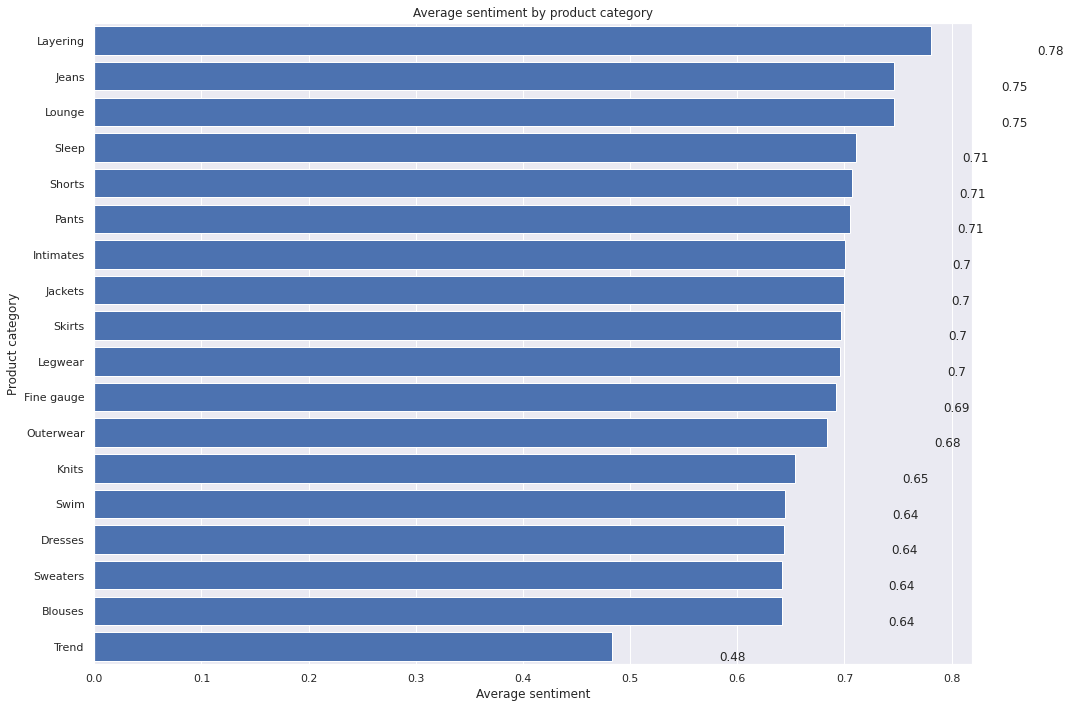

's3://sagemaker-us-east-1-170235698766/images/avg_sentiment_per_category.png'

In [24]:
#DATA VISUALIZATION
#statement to find the average sentiment per product category, showing the results in the descending order:
statement_avg_by_category = """SELECT product_category, AVG(sentiment) AS avg_sentiment FROM {} GROUP BY product_category ORDER BY avg_sentiment DESC""".format(table_name)

df_avg_by_category = wr.athena.read_sql_query(sql=statement_avg_by_category, database=database_name)

# Create plot
barplot = sns.barplot(data = df_avg_by_category, y='product_category',x='avg_sentiment', color="b", saturation=1)

# Set the size of the figure
sns.set(rc={'figure.figsize':(15.0, 10.0)})
    
# Set title and x-axis ticks 
plt.title('Average sentiment by product category')
#plt.xticks([-1, 0, 1], ['Negative', 'Neutral', 'Positive'])

# Helper code to show actual values afters bars 
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()),2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)
show_values_barplot(barplot, 0.1)

plt.xlabel("Average sentiment")
plt.ylabel("Product category")

plt.tight_layout()
# Do not change the figure name - it is used for grading purposes!
plt.savefig('./c1w2/avg_sentiment_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

# Upload image to S3 bucket
sess.upload_data(path='./c1w2/avg_sentiment_per_category.png', bucket=bucket, key_prefix="images")


## 2 Detect data bias with Clarify, balance the dataset, verify with Clarify


Job Name:  Clarify-Pretraining-Bias-2022-07-25-10-37-38-855
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-170235698766/data/transformed/womens_clothing_ecommerce_reviews_transformed.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-170235698766/bias/generated_bias_report/unbalanced/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-170235698766/bias/generated_bias_report/unbalanced', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'

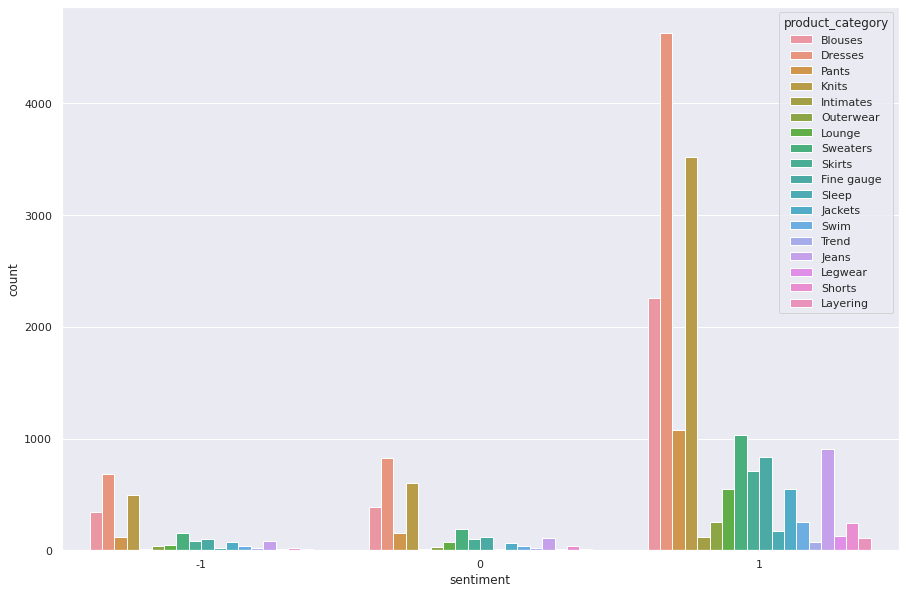

In [20]:
from sagemaker import clarify

#df_transformed is unbalanced coz there are way more positive reviews than negative or neutral. using a relatively small data subset you could visualize the occurring unbalances. At scale, you would need to perform bias analysis
sns.countplot(data=df_transformed, x='sentiment', hue='product_category') #counts of sentiment values for each category plotted

# CONFIGURE A DATACONFIG:input data info needs to be provided to the processor as dataconfig
bias_report_unbalanced_output_path = 's3://{}/bias/generated_bias_report/unbalanced'.format(bucket)

data_config_unbalanced = clarify.DataConfig(
    s3_data_input_path="s3://sagemaker-us-east-1-170235698766/data/transformed/womens_clothing_ecommerce_reviews_transformed.csv", # s3 uri of data to be analyzed
    s3_output_path=bias_report_unbalanced_output_path, # s3 location to save the clarify output
    label= 'sentiment', # target column
    headers=df_transformed.columns.to_list(), dataset_type='text/csv')

#Bias is measured by calculating a metric and comparing it across groups. To compute it, you will specify the required information in the BiasConfig API. SageMaker Clarify needs the sensitive columns (facet_name) and the desirable outcomes (label_values_or_threshold). Here product_category is the sensitive facet and the desired outcome is with the sentiment==1.
#SageMaker Clarify can handle both categorical and continuous data for label_values_or_threshold. In this case you are using categorical data.
bias_config_unbalanced = clarify.BiasConfig(
    label_values_or_threshold=[1], # desired sentiment
    facet_name='product_category') # sensitive column (facet)

#Configure Amazon SageMaker Clarify as a processing job
clarify_processor_unbalanced = clarify.SageMakerClarifyProcessor(role=role,instance_count=1,instance_type='ml.m5.large',sagemaker_session=sess)

#Run the Amazon SageMaker Clarify processing job
clarify_processor_unbalanced.run_pre_training_bias(
    data_config=data_config_unbalanced, # configured input/output data
    data_bias_config=bias_config_unbalanced, # configured sensitive groups
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"], # selector of a subset of potential metrics
    wait=False, # whether the call should wait until the job completes (default: True)
    logs=False # whether to show the logs produced by the job. Only meaningful when wait is True (default: True)
)
run_unbalanced_bias_processing_job_name = clarify_processor_unbalanced.latest_job.job_name

In [21]:
#Review the created Amazon SageMaker Clarify processing job and the Cloud Watch logs.
from IPython.core.display import display, HTML
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch logs</a> after about 5 minutes</b>'.format(region, run_unbalanced_bias_processing_job_name)))

In [22]:
#This cell will take approximately 5-10 minutes to run
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(processing_job_name=run_unbalanced_bias_processing_job_name,                                                                            sagemaker_session=sess)
#%%time
running_processor.wait(logs=False)

.........................................................................!

In [ ]:
# ANALYZE BIAS REPORT FROM ABOVE CLARIFY JOB
!aws s3 ls $bias_report_unbalanced_output_path/ #list job results
!aws s3 cp --recursive $bias_report_unbalanced_output_path ./c1w2/generated_bias_report/unbalanced/
display(HTML('<b>Review <a target="blank" href="./generated_bias_report/unbalanced/report.html">unbalanced bias report</a></b>'))

<a name='c1w2-3.'></a>
## Balance the dataset by `product_category` and `sentiment`

In [57]:
df_grouped_by = df_transformed.groupby(['product_category', 'sentiment'])
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))

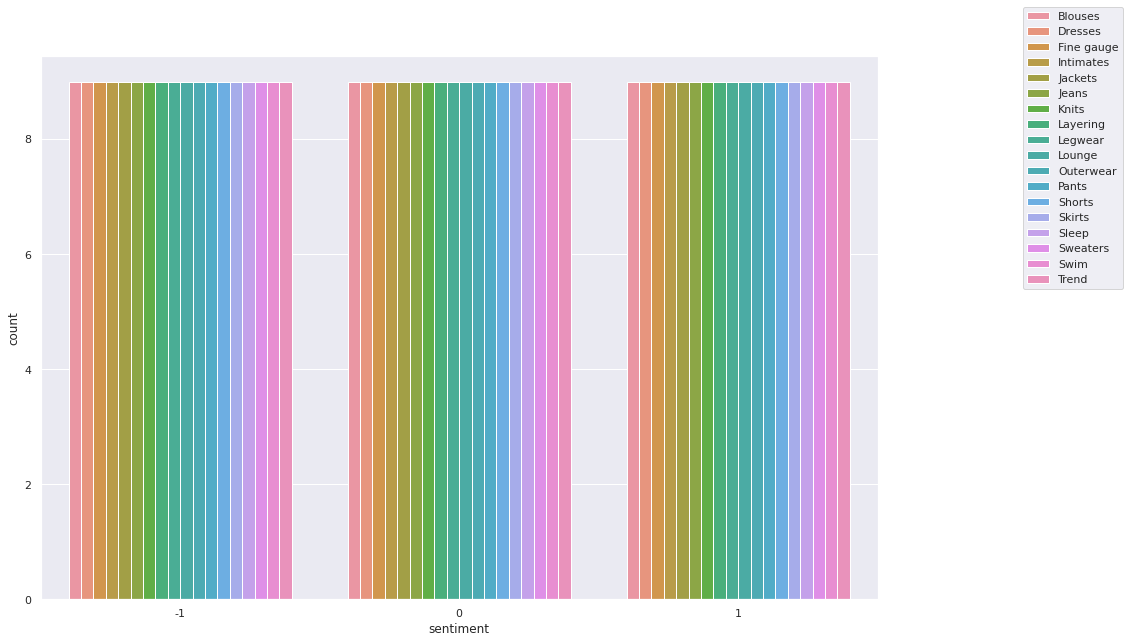

In [61]:
#plot the balanced dataset
import seaborn as sns
sns.countplot(data=df_balanced, x='sentiment', hue='product_category')
plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1.1))

In [62]:
#Analyze bias on balanced dataset 
#Save and upload balanced data to S3 bucket
path_balanced = './c1w2/womens_clothing_ecommerce_reviews_balanced.csv'
df_balanced.to_csv(path_balanced, index=False, header=True)
data_s3_uri_balanced = sess.upload_data(bucket=bucket, key_prefix='bias/balanced', path=path_balanced)

In [ ]:
#DATA CONFIG, BIAS CONFIG, 
bias_report_balanced_output_path = 's3://{}/bias/generated_bias_report/balanced'.format(bucket)

data_config_balanced = clarify.DataConfig(
    s3_data_input_path="s3://sagemaker-us-east-1-170235698766/bias/balanced/womens_clothing_ecommerce_reviews_balanced.csv", 
    s3_output_path=bias_report_balanced_output_path, label="sentiment", headers=df_balanced.columns.to_list(),dataset_type='text/csv')

bias_config_balanced = clarify.BiasConfig(label_values_or_threshold=[1],facet_name='product_category' )

clarify_processor_balanced = clarify.SageMakerClarifyProcessor(role=role,instance_count=1,instance_type='ml.m5.large',sagemaker_session=sess)

clarify_processor_balanced.run_pre_training_bias(data_config=data_config_balanced,data_bias_config=bias_config_balanced, methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],wait=False,logs=False)

run_balanced_bias_processing_job_name = clarify_processor_balanced.latest_job.job_name
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">processing job</a></b>'.format(region, run_balanced_bias_processing_job_name)))
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(processing_job_name=run_balanced_bias_processing_job_name,sagemaker_session=sess)

In [ ]:
#view and save the clarify balanced report
#%%time
running_processor.wait(logs=False)
!aws s3 ls $bias_report_balanced_output_path/
!aws s3 cp --recursive $bias_report_balanced_output_path ./c1w2/generated_bias_report/balanced/
display(HTML('<b>Review <a target="blank" href="./generated_bias_report/balanced/report.html">balanced bias report</a></b>'))